# LBS Descriptives

* This script is intended to make descriptives analysis of travel times extracted from LBS access ddbb obtained via "QueryingAccessLBS"

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import plotly.plotly
import plotly.tools as tls
import plotly.graph_objs as go

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import numpy as np
import datetime as dt
import time

In [3]:
import LBS_analysis_functionality

In [4]:
colors = [(85,98,112),(78,205,196),(199,244,100),(255,107,107),(196,77,88)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

In [5]:
month_list = ['01 Enero 2017',
              '02 Febrero 2017',
              '03 Marzo 2017',
              '04 Abril 2017',
              '05 Mayo 2017',
              '06 Junio 2017',
              '07 Julio 2017',
              '08 Agosto 2017',
              '09 Septiembre 2017',
              '10 Octubre 2017',
              '11 Noviembre 2017',
              '12 Diciembre 2017']

name_list = ['LBS Enero-2017',
             'LBS Febrero-2017',
             'LBS Marzo-2017',
             'LBS Abril-2017',
             'LBS Mayo-2017',
             'LBS Junio-2017',
             'LBS Julio-2017',
             'LBS Agosto-2017',
             'LBS SEP-2017',
             'LBS OCT-2017',
             'LBS NOV-2017',
             'LBS DIC-2017']

### Analyzing 07:30:00 AM during working days

In [6]:
#complete_lbs = pd.DataFrame()
#tic = time.clock()
#for month,name in zip(month_list,name_list):
#    print(month + ' is being analyzed')
#    LBS_builder = LBS_analysis_functionality.LBS_analysis_functionality_class(month,name)
#    LBS_builder.loadLBS()
#    #LBS_builder.simplifyingLBS_byDayByPeriod('monday',4) #Be aware that asking for period == 4 already omits non-working days
#    #LBS_builder.simplifyingLBS_byPeriod(4) #Be aware that asking for period == 4 already omits non-working days
#    LBS_builder.simplifyingLBS_byMidHr('07:30:00', 'laboral')
#    LBS_builder.travelTimeProcessing()
#    LBS_builder.mergeTurnstileDatabase()
#    #Retrieving the info.
#    lbs_df = LBS_builder.lbs_df
#    complete_lbs = pd.concat([complete_lbs,lbs_df])
#
#toc = time.clock()
#print(toc-tic)

In [7]:
#Summary to a file.
#complete_lbs.to_csv('G:/LeoCamus/0_LBS/2017/13 Summary/2017_LBS_07.30.00.csv', sep=';', encoding='latin-1')
#Reading summary from file.
complete_lbs = pd.read_csv('G:/LeoCamus/0_LBS/2017/13 Summary/2017_LBS_07.30.00.csv', sep=';', encoding='latin-1')

* Recognizing useful routes...

In [8]:
grouped_complete = complete_lbs.groupby(['ser_sen','no_torniquete','torniquete_mariposa']).size().to_frame('group_size')

In [9]:
grouped_complete_pcts = grouped_complete.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))

In [10]:
grouped_complete_pcts.loc[(40<=grouped_complete_pcts['group_size'])&(grouped_complete_pcts['group_size']<=60),:].head()

group_size
ser_sen no_torniquete torniquete_mariposa            
128I    0             1                     50.182927
        1             0                     49.817073
128R    0             1                     48.845687
        1             0                     51.154313
130I    0             1                     51.297814

* Separating dataset and plotting

In [11]:
lbs_no_turnstile = complete_lbs.loc[complete_lbs['no_torniquete']==1,:]
lbs_butterfly_turnstile = complete_lbs.loc[complete_lbs['torniquete_mariposa']==1,:]

In [12]:
def plotByRoute(route, step, mid_hr, save):
    no_turnstile_time = lbs_no_turnstile.loc[lbs_no_turnstile['ser_sen']==route,'Tiempo_Expedicion_secs']
    turnstile_time = lbs_butterfly_turnstile.loc[lbs_butterfly_turnstile['ser_sen']==route,'Tiempo_Expedicion_secs']
    
    mean_no_turnstile_time = no_turnstile_time.mean()
    std_no_turnstile_time = no_turnstile_time.std()
    n_obs_no_turnstile = len(no_turnstile_time.index)
    
    mean_turnstile_time = turnstile_time.mean()
    std_turnstile_time = turnstile_time.std()
    n_obs_turnstile = len(turnstile_time.index)
    
    max_time = max(max(no_turnstile_time),max(turnstile_time))
    bins = range(0,int(max_time),step)
    
    hist_fig, ax = plt.subplots()

    plot1 = ax.hist(no_turnstile_time.values, bins=bins, color=colors[0], alpha=0.8, weights = np.zeros_like(no_turnstile_time) + 100. / no_turnstile_time.size, label='sin torniquete')
    plot2 = ax.hist(turnstile_time.values, bins=bins, color=colors[3], alpha = 0.8, weights = np.zeros_like(turnstile_time) + 100. / turnstile_time.size, label='con torniquete mariposa')


    ax.set_title('Tiempo de expedición '+ route + ' - ' + mid_hr + ' - Laboral 2017')
    ax.set_xlabel('Tiempo expedición [s]')
    ax.set_ylabel('Frecuencia [%]')
    ax.legend()
    
    print('Mean, NO TURNSTILE: ' + str(mean_no_turnstile_time))
    print('St.D., NO TURNSTILE: ' + str(std_no_turnstile_time))
    print('Obs., NO TURNSTILE: ' + str(n_obs_no_turnstile))
    print('-----')
    print('Mean, TURNSTILE: ' + str(mean_turnstile_time))
    print('St.D., TURNSTILE: ' + str(std_turnstile_time))
    print('Obs., TURNSTILE: ' + str(n_obs_turnstile))
    
    if save==True:
        plt.savefig('G:/LeoCamus/0_LBS/2017/13 Summary/' + route + '_' + str(step) + '_' + mid_hr +'.pdf')

In [13]:
#plotByRoute('F13I',200, '07.30.AM', True)

Mean, NO TURNSTILE: 3351.628712871287
St.D., NO TURNSTILE: 463.0682738941556
Obs., NO TURNSTILE: 808
-----
Mean, TURNSTILE: 3472.94227994228
St.D., TURNSTILE: 405.03628198861924
Obs., TURNSTILE: 693


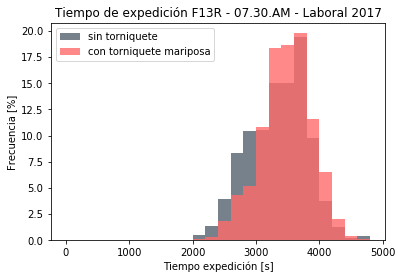

In [14]:
plotByRoute('F13R',200, '07.30.AM', False)

In [15]:
#plotByRoute('F03I',200, '07.30.AM', True)

In [16]:
#plotByRoute('F03R',200, '07.30.AM', True)

In [17]:
#plotByRoute('F06I',200, '07.30.AM', True)

Mean, NO TURNSTILE: 4757.625
St.D., NO TURNSTILE: 542.8160368191608
Obs., NO TURNSTILE: 728
-----
Mean, TURNSTILE: 5012.559523809524
St.D., TURNSTILE: 521.0939464080025
Obs., TURNSTILE: 420


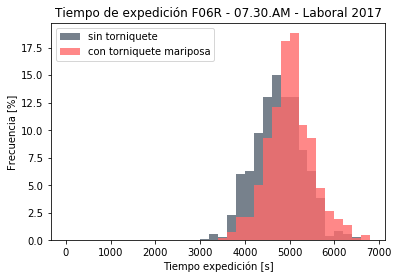

In [18]:
plotByRoute('F06R',200, '07.30.AM', False)

In [19]:
#plotByRoute('F53eR',200, '07.30.AM', True)

In [20]:
#plotByRoute('F53eI',200, '07.30.AM', True)

In [21]:
#plotByRoute('511I',200, '07.30.AM', True)

Mean, NO TURNSTILE: 6748.819852941177
St.D., NO TURNSTILE: 515.1789434857062
Obs., NO TURNSTILE: 272
-----
Mean, TURNSTILE: 6916.013440860215
St.D., TURNSTILE: 477.5098845529909
Obs., TURNSTILE: 372


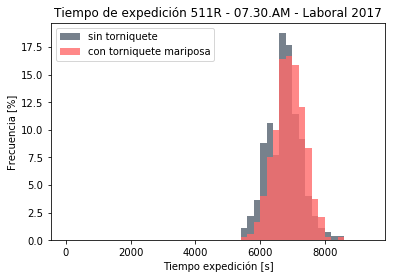

In [22]:
plotByRoute('511R',200, '07.30.AM', False)

In [23]:
#plotByRoute('128I',200, '07.30.AM', True)

In [24]:
#plotByRoute('128R',200, '07.30.AM', True)

In [25]:
#plotByRoute('130I',200, '07.30.AM', True)

In [26]:
#plotByRoute('130R',200, '07.30.AM', True)

In [27]:
#plotByRoute('626I',200, '07.30.AM', True)

In [28]:
#plotByRoute('626R',200, '07.30.AM', True)

In [29]:
#plotByRoute('B66I',200, '07.30.AM', True)

Mean, NO TURNSTILE: 3384.0106194690266
St.D., NO TURNSTILE: 744.9246165110868
Obs., NO TURNSTILE: 565
-----
Mean, TURNSTILE: 3487.2145833333334
St.D., TURNSTILE: 544.2618814610425
Obs., TURNSTILE: 480


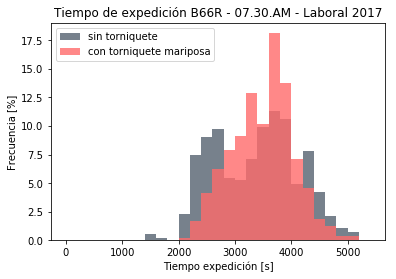

In [30]:
plotByRoute('B66R',200, '07.30.AM', False)

In [31]:
#plotByRoute('F16I',200, '07.30.AM', True)

In [32]:
#plotByRoute('F16R',200, '07.30.AM', True)

### Analyzing 15:00:00 during working days

In [33]:
#complete_lbs = pd.DataFrame()
#tic = time.clock()
#for month,name in zip(month_list,name_list):
#    print(month + ' is being analyzed')
#    LBS_builder = LBS_analysis_functionality.LBS_analysis_functionality_class(month,name)
#    LBS_builder.loadLBS()
#    #LBS_builder.simplifyingLBS_byDayByPeriod('monday',4) #Be aware that asking for period == 4 already omits non-working days
#    #LBS_builder.simplifyingLBS_byPeriod(4) #Be aware that asking for period == 4 already omits non-working days
#    LBS_builder.simplifyingLBS_byMidHr('15:00:00', 'laboral')
#    LBS_builder.travelTimeProcessing()
#    LBS_builder.mergeTurnstileDatabase()
#    #Retrieving the info.
#    lbs_df = LBS_builder.lbs_df
#    complete_lbs = pd.concat([complete_lbs,lbs_df])
#
#toc = time.clock()
#print(toc-tic)

In [34]:
#Summary to a file.
#complete_lbs.to_csv('G:/LeoCamus/0_LBS/2017/13 Summary/2017_LBS_15.00.00.csv', sep=';', encoding='latin-1')
#Reading summary from file.
complete_lbs = pd.read_csv('G:/LeoCamus/0_LBS/2017/13 Summary/2017_LBS_15.00.00.csv', sep=';', encoding='latin-1')

In [35]:
lbs_no_turnstile = complete_lbs.loc[complete_lbs['no_torniquete']==1,:]
lbs_butterfly_turnstile = complete_lbs.loc[complete_lbs['torniquete_mariposa']==1,:]

Mean, NO TURNSTILE: 4354.66875
St.D., NO TURNSTILE: 444.71758844030813
Obs., NO TURNSTILE: 480
-----
Mean, TURNSTILE: 4610.9925650557625
St.D., TURNSTILE: 505.5575612190064
Obs., TURNSTILE: 269


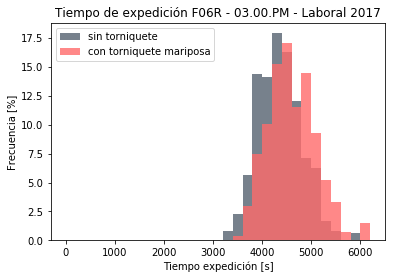

In [36]:
plotByRoute('F06R',200, '03.00.PM', True)

Mean, NO TURNSTILE: 3341.4941860465115
St.D., NO TURNSTILE: 405.39256530549153
Obs., NO TURNSTILE: 516
-----
Mean, TURNSTILE: 3436.590395480226
St.D., TURNSTILE: 397.06211331961316
Obs., TURNSTILE: 354


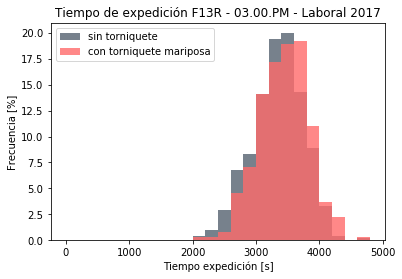

In [37]:
plotByRoute('F13R',200, '03.00.PM', True)

Mean, NO TURNSTILE: 6902.310144927536
St.D., NO TURNSTILE: 669.6183653953105
Obs., NO TURNSTILE: 345
-----
Mean, TURNSTILE: 7140.599337748345
St.D., TURNSTILE: 566.5748067942242
Obs., TURNSTILE: 302


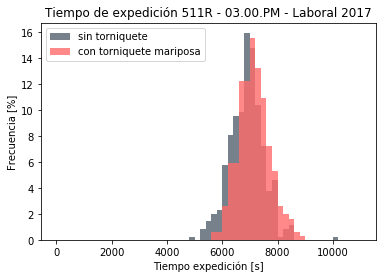

In [38]:
plotByRoute('511R',200, '03.00.PM', True)

Mean, NO TURNSTILE: 3038.7095115681236
St.D., NO TURNSTILE: 466.62736566630815
Obs., NO TURNSTILE: 389
-----
Mean, TURNSTILE: 3257.1894409937886
St.D., TURNSTILE: 457.1910697735506
Obs., TURNSTILE: 322


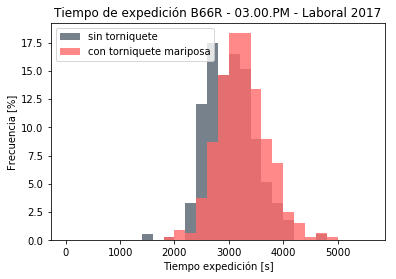

In [39]:
plotByRoute('B66R',200, '03.00.PM', True)

In [ ]:
#f = {'Tiempo_Expedicion_secs':['count', 'mean', 'std']}

In [ ]:
#grouped_lbs_df = lbs_df.groupby(['ser_sen','Fecha','no_torniquete','torniquete_mariposa']).agg(f)

In [ ]:
lbs_no_turnstile = lbs_df.loc[lbs_df['no_torniquete']==1,:]
lbs_butterfly_turnstile = lbs_df.loc[lbs_df['torniquete_mariposa']==1,:]

In [ ]:
fig, ax = plt.subplots()
ax.scatter(intersected_lbs['Tiempo_Expedicion_secs_no_turnstile'].values, intersected_lbs['Tiempo_Expedicion_secs_turnstile'].values, color='blue')
#ax.scatter(intersected_lbs['LBS.[Distancia (m)]_turnstile'].values, intersected_lbs['Tiempo_Expedicion_secs_turnstile'].values, color='red')

In [ ]:
import statsmodels.api as sm

In [ ]:
Y = intersected_lbs.loc[:,'Tiempo_Expedicion_secs_turnstile']
X = intersected_lbs.loc[:,'Tiempo_Expedicion_secs_no_turnstile']

X = sm.add_constant(X)
m1_1 = sm.OLS(Y, X)
results_m1_1 = m1_1.fit()

print(results_m1_1.summary())

In [ ]:
f = {'Tiempo_Expedicion_secs_no_turnstile':['count', 'mean', 'std'], 'Tiempo_Expedicion_secs_turnstile':['count','mean', 'std']}

In [ ]:
grouped_intersected = intersected_lbs.groupby(['ser_sen'])['Tiempo_Expedicion_secs_no_turnstile','Tiempo_Expedicion_secs_turnstile'].agg(f)

In [ ]:
grouped_intersected.head()